# Connect to the drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd "/gdrive/My Drive/"

/gdrive/My Drive


# Import libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline
!pip install keras-cv --upgrade
import keras_cv


2.17.1


In [ ]:
data = np.load('cleaned_training_set.npz')
images = data['images']
labels = data['labels']


# Plot images

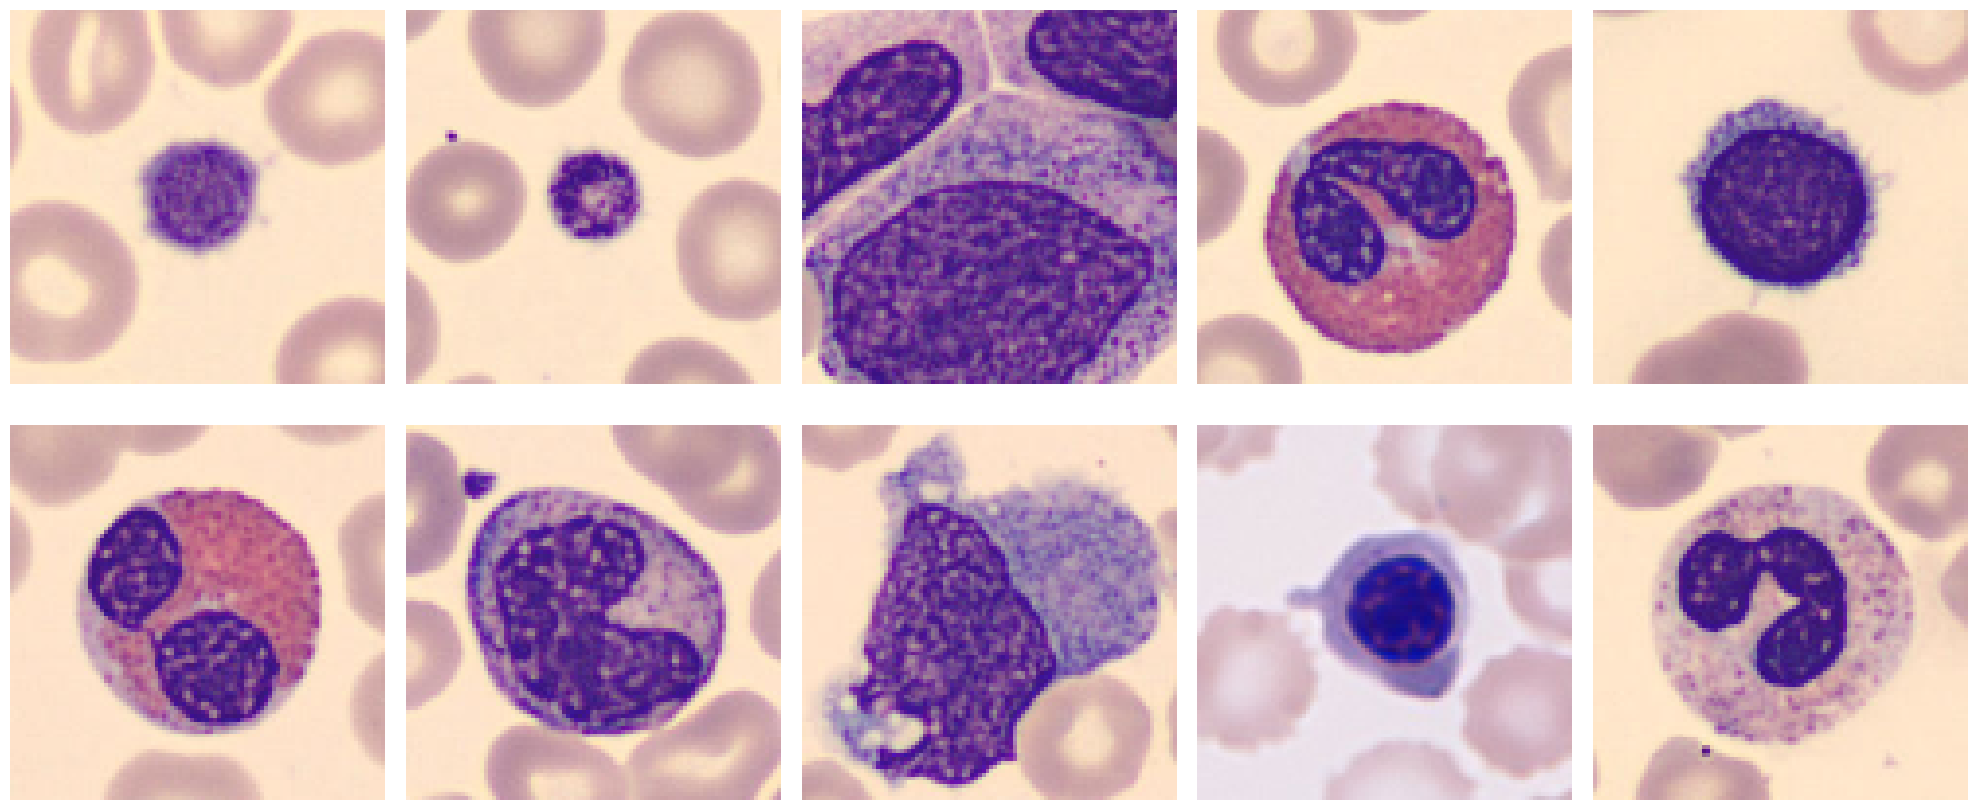

In [ ]:
# Number of images to display
num_img = 10

# Select random indices from the training set
random_indices = random.sample(range(len(images)), num_img)

# Create subplot layout for images
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]

    # Display the image at the selected index
    ax.imshow(images[idx])

    # Remove axis lines for clearer display
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Data balancing

In [ ]:
n_images = images / 255.0

datagen = tfk.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Get 5500 images per class

In [ ]:
classIndices = {}
maxCount = 5500

#for each class
for i in range(8):
  currIndices = np.where(labels==i)[0]
  #maxCount = max(maxCount, len(currIndices))
  classIndices[i] = currIndices

print(f"Max values of class: {maxCount}")

#increase the dataset to make it balanced
for i in range(8):
  currImages = n_images[classIndices[i]]
  currAugImages = []
  currAugLabel = []
  currLen = len(classIndices[i])
  counter = currLen
  for currAug in datagen.flow(currImages, batch_size=1):
      if counter < maxCount:
          currAugImages.append(currAug)
          currAugLabel.append([i])
          counter +=1
      else:
        break
  if len(currAugImages) != 0:
    toAddImages = np.concatenate(currAugImages)
    toAddLabels = np.stack(currAugLabel)
    n_images = np.concatenate([n_images, toAddImages])
    labels = np.concatenate([labels, toAddLabels])

Max values of class: 5500


In [ ]:
print(n_images.shape)
print(labels.shape)
X_train, X_test, y_train, y_test = train_test_split(n_images, labels, test_size=0.1, random_state=47)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#remove from memory n_imges and labels
del n_images
del labels

(44000, 96, 96, 3)
(44000, 1)


In [ ]:
# Convert class labels to categorical format for training, validation, and test sets
y_train = tfk.utils.to_categorical(y_train, num_classes=8)
y_test = tfk.utils.to_categorical(y_test, num_classes=8)


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (39600, 96, 96, 3), y_train shape: (39600, 8)
X_test shape: (4400, 96, 96, 3), y_test shape: (4400, 8)


# Define augmentation functions/layers and apply them

In [ ]:
target_size = (96, 96)
scale_factor = (0.8, 1.25)
value_range = (0, 1)
factor = 0.2


aug_layers = [keras_cv.layers.RandAugment(value_range, augmentations_per_image=3, magnitude=0.5, magnitude_stddev=0.15, rate=0.9090909090909091,geometric=True, seed=None),
    #keras_cv.layers.AutoContrast((0, 1)),
    keras_cv.layers.ChannelShuffle(groups=3, seed=None),
    keras_cv.layers.GridMask(ratio_factor=(0, 0.5), rotation_factor=0.15, fill_mode="constant", fill_value=0.0, seed=None),
    keras_cv.layers.JitteredResize(target_size=(96, 96), scale_factor=(0.8, 1.2), crop_size=None, bounding_box_format=None, interpolation="bilinear", seed=None),
    keras_cv.layers.RandomChannelShift(value_range=(0, 1), factor=0.2, channels=3, seed=None),
    keras_cv.layers.RandomColorDegeneration(factor=0.2, seed=None),
    #keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2, fill_mode="constant", fill_value=0.0, seed=None),
    #keras_cv.layers.RandomHue(factor=0.2, value_range=(0, 1), seed=None),
    #keras_cv.layers.RandomSharpness(factor=0.5, value_range=(0, 1), seed=None),
    #keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, interpolation="bilinear", fill_mode="reflect", fill_value=0.0, bounding_box_format=None, seed=None),
    keras_cv.layers.Solarization(value_range=(0, 1), addition_factor=0.0, threshold_factor=0.0, seed=None)
]
pipeline_layer = keras_cv.layers.RandomAugmentationPipeline(
    layers=aug_layers, augmentations_per_image=3
)
def cutmix_or_mixup(samples):
    number = tf.random.uniform(())
    if number > 0.75:
        samples = keras_cv.layers.CutMix(alpha=0.1)(samples)
    elif number > 0.5:
        samples = keras_cv.layers.MixUp()(samples)
    elif number > 0.25:
        samples = keras_cv.layers.FourierMix(alpha=0.5, decay_power=3)(samples)
    return samples
def preprocess_image(image, label):
    image = tf.image.resize(image, (96, 96))
    image = tf.image.convert_image_dtype(image, "float32")
    label = tfk.ops.cast(label, dtype="float32")
    return image, label
def prep_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels
def pipeline(samples):
    return pipeline_layer(samples)  # Apply other pipeline layer
def preprocess(img, label):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.cast(img, tf.float32)
    return {"images": img, "labels": label}

train_ds_simple = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_ds_simple = train_ds_simple.map(preprocess_image)

train_ds_simple = train_ds_simple.map(preprocess).batch(64).map(cutmix_or_mixup).map(pipeline).map(prep_for_model).prefetch(tf.data.AUTOTUNE)

#Convert to numpy type
listBatches = []
listLabelBatches =  []

for dataset in [train_ds_simple]:
    for curr_img_batch, curr_label_batch in dataset:
        listBatches.append(np.array(curr_img_batch))

        # Ensure that labels are one-hot encoded correctly
        currStack = []
        for label in curr_label_batch:
            # Assuming `label` is an integer index, we convert it to one-hot encoding
            lbl = np.zeros(8)
            maxIndex = np.argmax(label)
            lbl[maxIndex]=1
            currStack.append(lbl)

        listLabelBatches.append(np.stack(currStack))

# Concatenate the image and label batches
X_train = np.concatenate(listBatches)
y_train = np.concatenate(listLabelBatches)

print(X_train.shape)
print(y_train.shape)


#free
del train_ds_simple



(39600, 96, 96, 3)
(39600, 8)


# Plot images

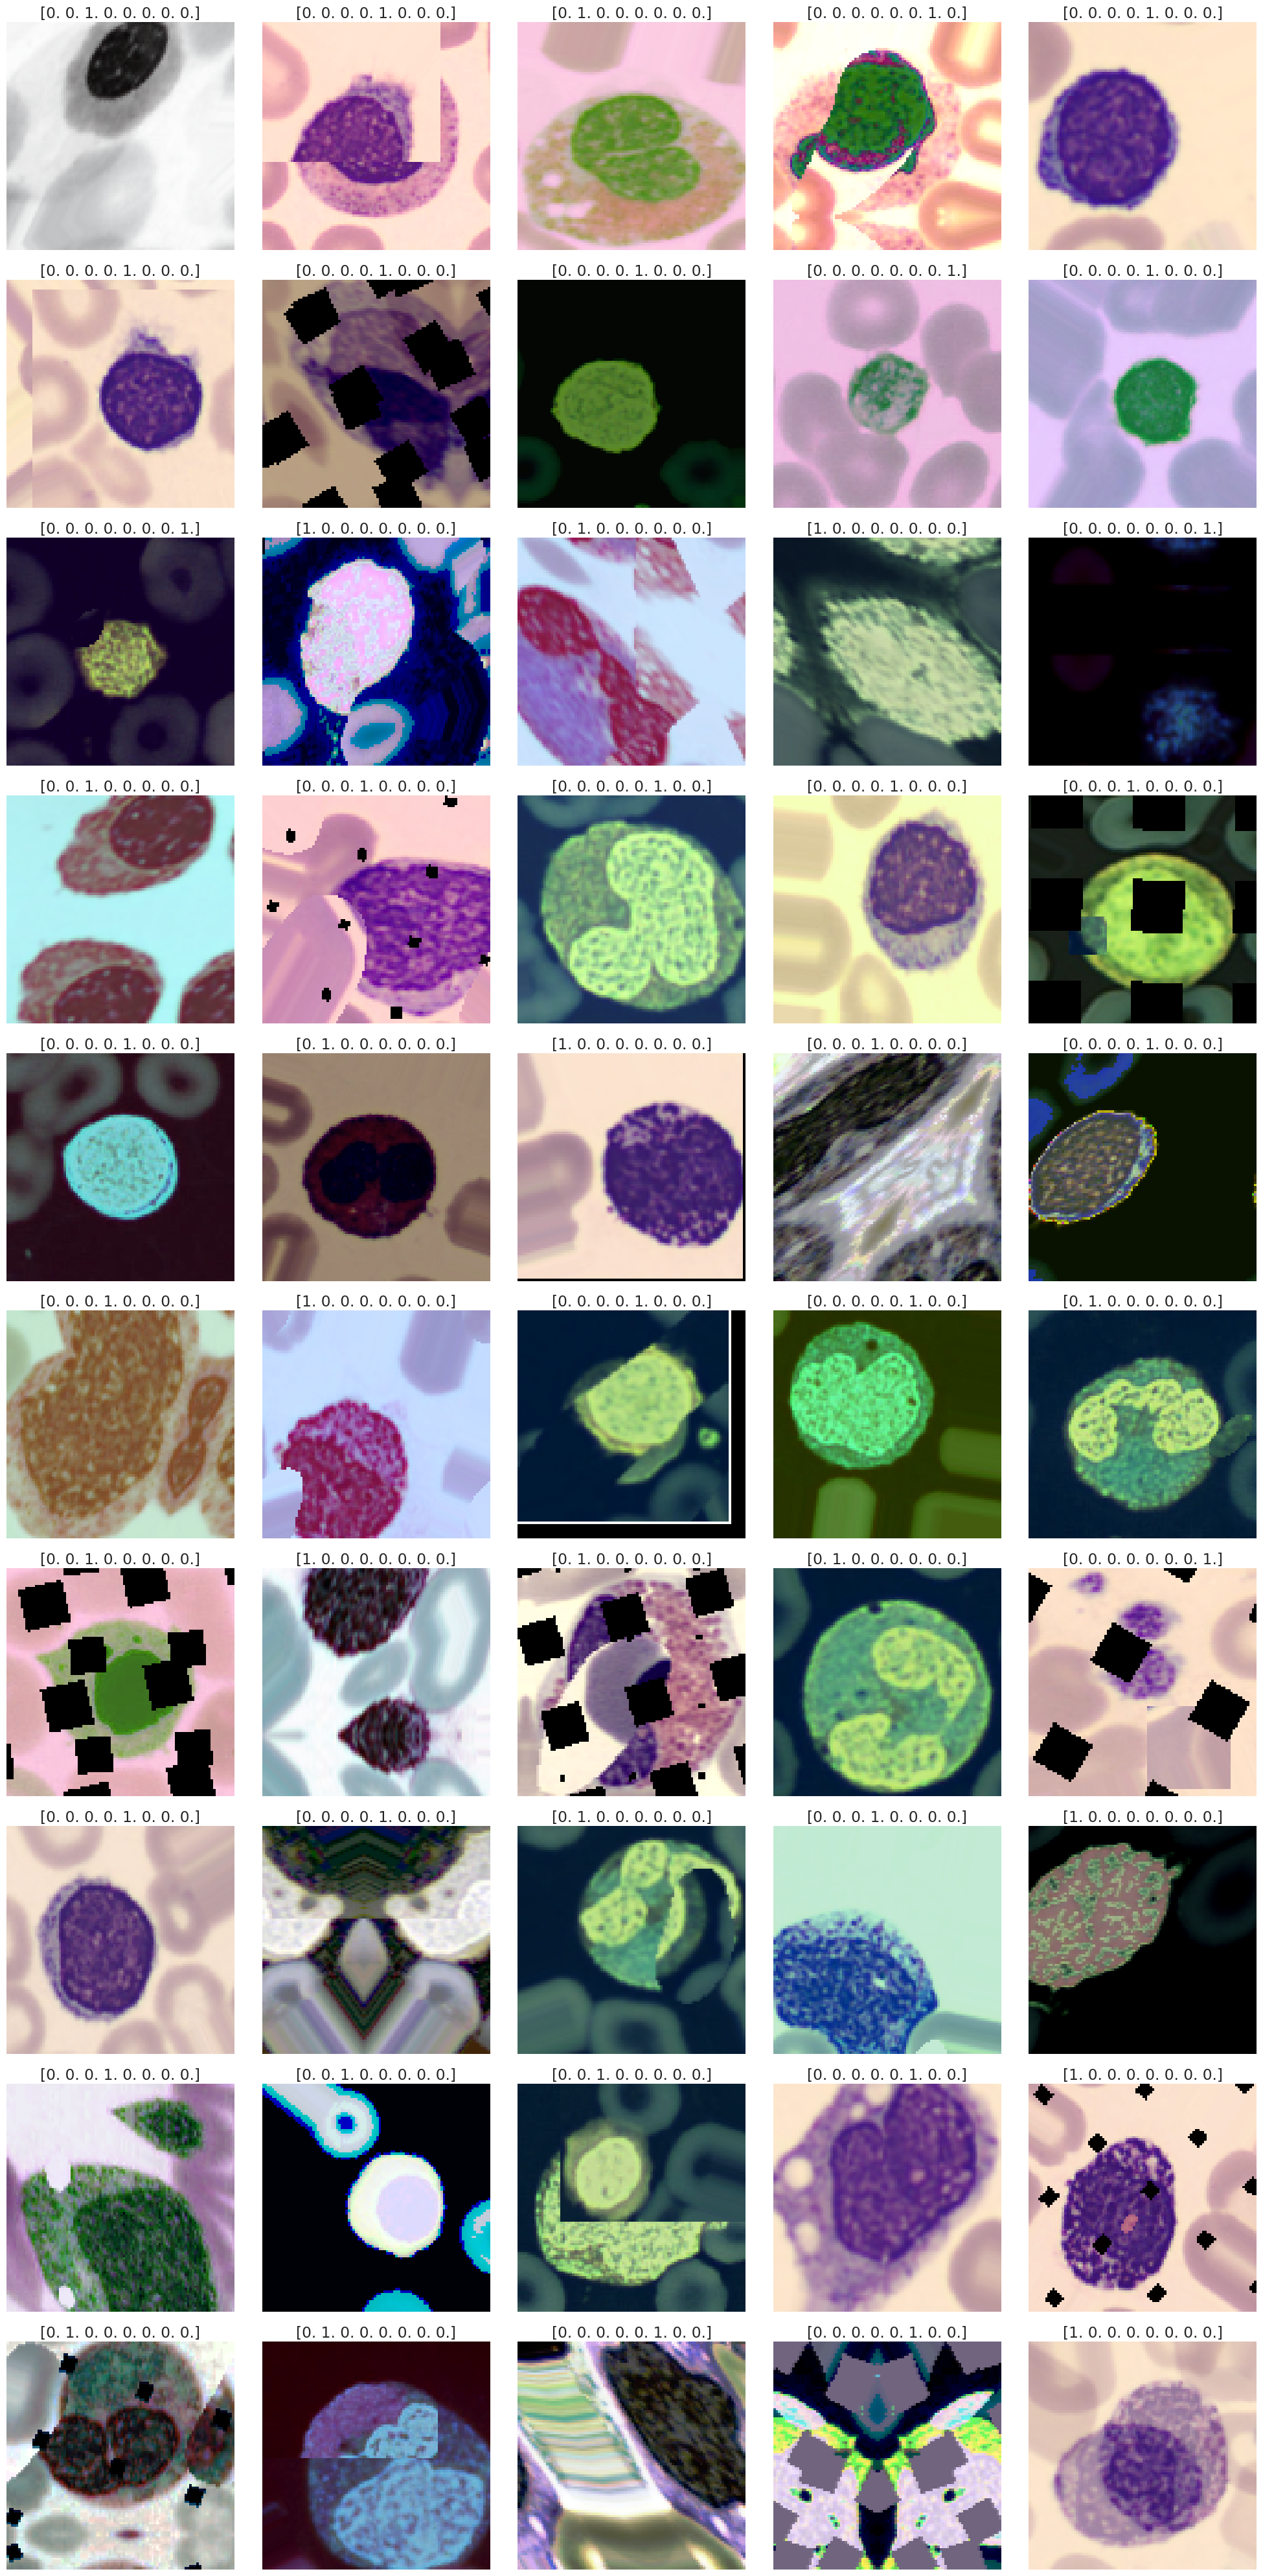

In [ ]:
#Round up
def ceil(x):
  return int(x) + int((x>0) and (x - int(x)) > 0)

num_img = 50

random_indices = random.sample(range(len(X_train)), num_img)

# Calculate number of rows and columns for the subplot
num_cols = 5
num_rows = ceil(num_img / num_cols)  # This will automatically handle different numbers of images

# Create subplot layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))


axes = axes.flatten()

for i, idx in enumerate(random_indices):
     ax = axes[i]  # Select the current axis

     # Display the image at the selected index
     ax.imshow(X_train[idx])

     # Add class name as title, formatting it to replace underscores with spaces and capitalise
     ax.set_title(y_train[idx], pad=5)

     # Remove axis lines for clearer display
     ax.axis('off')

# Turn off any remaining unused subplots (if num_img is less than the total axes)
for j in range(i + 1, len(axes)):
     axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Define the model

Model: "convnext_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_prestem_no… │ (None, 96, 96, 3)      │              0 │ input_layer[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stem        │ (None, 24, 24, 128)    │          6,528 │ convnext_base_prestem… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └                      │ (None, 24, 24, 128)    │          6,272 │ -                      │
│ convnext_base_stem_conv   │                        │                │                        │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └                      │ (None, 24, 24, 128)    │            256 │ -                      │
│ convnext_base_stem_layer… │                        │                │                        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 24, 24, 128)    │          6,400 │ convnext_base_stem[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 24, 24, 128)    │            256 │ convnext_base_stage_0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 24, 24, 512)    │         66,048 │ convnext_base_stage_0… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 24, 24, 512)    │              0 │ convnext_base_stage_0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 24, 24, 128)    │         65,664 │ convnext_base_stage_0… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 24, 24, 128)    │            128 │ convnext_base_stage_0… │
│ (LayerScale)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 24, 24, 128)    │              0 │ convnext_base_stage_0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 24, 24, 128)    │              0 │ convnext_base_stem[0]… │
│                      

 Total params: 87,566,464 (334.04 MB)

 Trainable params: 87,566,464 (334.04 MB)

 Non-trainable params: 0 (0.00 B)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.949603 to fit



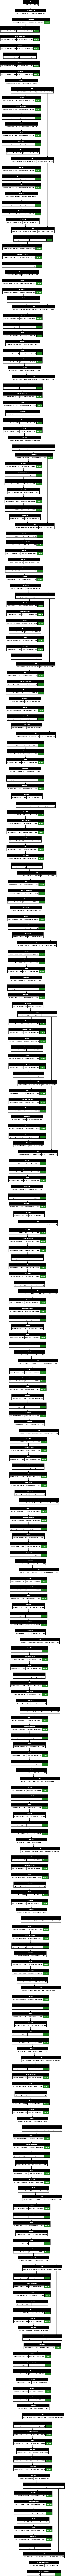

In [ ]:
model = tfk.applications.ConvNeXtBase(
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(96, 96, 3),
    pooling='avg',
    classes=8,
    classifier_activation="softmax",
    name="convnext_base",
)

model.summary(expand_nested=True)
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

# Features extraction

In [ ]:
model.trainable = False


inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')


augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    #tfkl.RandomTranslation(0.05, 0.05, fill_mode = "reflect"),
    tfkl.RandomRotation(0.5, fill_mode = "reflect"),
    tfkl.RandomZoom((0.1, -0.1), (0.1, -0.1), fill_mode="wrap", interpolation="bilinear"),
    #tfkl.RandomBrightness(0.2, value_range=(0, 255.0)),
    #tfkl.RandomContrast(0.2),
    tfkl.GaussianNoise(0.1, seed=None)
], name='preprocessing')

x = augmentation(inputs)
x = model(x)
x = tfkl.Dropout(0.4, name='dropout1')(x)
x = tfkl.Dense(256, activation='relu', name='dense1')(x)
x = tfkl.Dropout(0.4, name='dropout2')(x)
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense2')(x)


model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.99,
    staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.Lion(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.99,
    weight_decay=0.0001,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    loss_scale_factor=None,
    gradient_accumulation_steps=None,
    name="lion"
),
    loss=tfk.losses.CategoricalCrossentropy(),        # Categorical cross-entropy for multi-class classification
    metrics=['accuracy', 'precision', 'recall', 'AUC']                    # Track accuracy during training
)
for layer in model.layers:
    print(layer.name)

model.summary(expand_nested=True)

input_layer
preprocessing
convnext_base
dropout1
dense1
dropout2
dense2


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ gaussian_noise (GaussianNoise)  │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_base (Functional)           │ (None, 1024)                │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 96, 96, 3)           │               0 │
│ convnext_base_prestem_normalization  │                             │                 │
│ (Normalization)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ convnext_base_stem (Sequential) │ (None, 24, 24, 128)         │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ convnext_base_stem_conv      │ (None, 24, 24, 128)         │           6,272 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ convnext_base_stem_layernorm │ (None, 24, 24, 128)         │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 128)         │           6,400 │
│ convnext_base_stage_0_block_0_depth… │                             │                 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 128)         │             256 │
│ convnext_base_stage_0_block_0_layer… │                             │                 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 512)         │          66,048 │
│ convnext_base_stage_0_block_0_point… │                             │                 │
│ (Dense)                              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 512)         │              

 Total params: 87,830,920 (335.05 MB)

 Trainable params: 264,456 (1.01 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

# Calculate the weights of each class after augmentation

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
decodeLabels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(decodeLabels), y=decodeLabels)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 0.9831181727904668, 1: 1.0052802599512591, 2: 0.9927797833935018, 3: 1.0046681550639334, 4: 0.9961762930167035, 5: 1.0112359550561798, 6: 1.0060975609756098, 7: 1.0012135922330097}


# Resume last train

In [ ]:
model = tfk.models.load_model('LastDanceNoFT_A87.11.keras')

### Resuming saved train with doing just one epoch starting from the last state

In [ ]:
# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]
# Fine-tune the model with a very low learning rate
tl_history = model.fit(
    x=X_train*255.0,                            # Training data
    y=y_train,                            # Training labels
    batch_size=100,                # Batch size
    epochs=1,                        # Number of epochs
    validation_data=(X_test*255.0, y_test),       # Validation data
    callbacks=callbacks ,
    class_weight=class_weight_dict        # Class weights for imbalanced classes
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'LastaDanceNOFT_A' + str(final_val_accuracy) + '.keras'
print(model_filename)
model.save(model_filename)

# Free memory by deleting the model instance
del model

396/396 ━━━━━━━━━━━━━━━━━━━━ 349s 838ms/step - AUC: 0.8584 - accuracy: 0.5035 - loss: 1.5946 - precision: 0.7341 - recall: 0.3222 - val_AUC: 0.9890 - val_accuracy: 0.8791 - val_loss: 0.4177 - val_precision: 0.9357 - val_recall: 0.8000
Final validation accuracy: 87.91%
LastaDanceNOFT_A87.91.keras


# Fine-tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('LastaDanceNOFT_A87.91.keras')

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ gaussian_noise (GaussianNoise)  │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_base (Functional)           │ (None, 1024)                │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 96, 96, 3)           │               0 │
│ convnext_base_prestem_normalization  │                             │                 │
│ (Normalization)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ convnext_base_stem (Sequential) │ (None, 24, 24, 128)         │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ convnext_base_stem_conv      │ (None, 24, 24, 128)         │           6,272 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ convnext_base_stem_layernorm │ (None, 24, 24, 128)         │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 128)         │           6,400 │
│ convnext_base_stage_0_block_0_depth… │                             │                 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 128)         │             256 │
│ convnext_base_stage_0_block_0_layer… │                             │                 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 512)         │          66,048 │
│ convnext_base_stage_0_block_0_point… │                             │                 │
│ (Dense)                              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 512)         │              

 Total params: 126,156,433 (481.25 MB)

 Trainable params: 38,325,512 (146.20 MB)

 Non-trainable params: 49,505,408 (188.85 MB)

 Optimizer params: 38,325,513 (146.20 MB)

In [ ]:
# Set the model layers as trainable
ft_model.get_layer('convnext_base').trainable = True

# Set all layers as non-trainable
for layer in ft_model.get_layer('convnext_base').layers:
    layer.trainable = False

# Enable training only for Conv2D,DepthwiseConv2D and BatchNorm layers
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D) or isinstance(layer, tf.keras.layers.BatchNormalization) or isinstance(layer, tf.keras.layers.Dense):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

# Put L2 reg. for Conv2D,DepthwiseConv2D and BatchNorm layers
for layer in ft_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D) or isinstance(layer, tf.keras.layers.BatchNormalization) or isinstance(layer, tf.keras.layers.Dense):  # Only apply to Conv2D layers
        layer.kernel_regularizer = tfk.regularizers.l2(0.005)

3 convnext_base_stage_0_block_0_depthwise_conv Conv2D True
5 convnext_base_stage_0_block_0_pointwise_conv_1 Dense True
7 convnext_base_stage_0_block_0_pointwise_conv_2 Dense True
10 convnext_base_stage_0_block_1_depthwise_conv Conv2D True
12 convnext_base_stage_0_block_1_pointwise_conv_1 Dense True
14 convnext_base_stage_0_block_1_pointwise_conv_2 Dense True
17 convnext_base_stage_0_block_2_depthwise_conv Conv2D True
19 convnext_base_stage_0_block_2_pointwise_conv_1 Dense True
21 convnext_base_stage_0_block_2_pointwise_conv_2 Dense True
25 convnext_base_stage_1_block_0_depthwise_conv Conv2D True
27 convnext_base_stage_1_block_0_pointwise_conv_1 Dense True
29 convnext_base_stage_1_block_0_pointwise_conv_2 Dense True
32 convnext_base_stage_1_block_1_depthwise_conv Conv2D True
34 convnext_base_stage_1_block_1_pointwise_conv_1 Dense True
36 convnext_base_stage_1_block_1_pointwise_conv_2 Dense True
39 convnext_base_stage_1_block_2_depthwise_conv Conv2D True
41 convnext_base_stage_1_block_2_

In [ ]:
# Set the number of layers to freeze
N = int(0.75 * len(ft_model.get_layer('convnext_base').layers))

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True, show_trainable=True)



0 input_layer False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 convnext_base_stage_0_block_1_depthwise_conv False
11 convnext_base_stage_0_block_1_layernorm False
12 convnext_base_stage_0_block_1_pointwise_conv_1 False
13 convnext_base_stage_0_block_1_gelu False
14 convnext_base_stage_0_block_1_pointwise_conv_2 False
15 convnext_base_stage_0_block_1_layer_scale False
16 convnext_base_stage_0_block_1_identity False
17 convnext_base_stage_0_block_2_depthwise_conv False
18 convnext_base_stage_0_block_2_layernorm False
19 convnext_base_stage_0_block_2_pointwise_conv_1 False
20 convnext_base_stage_0_block_2_gelu Fal

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip (RandomFlip)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation_1              │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_zoom (RandomZoom)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ gaussian_noise (GaussianNoise) │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ convnext_base (Functional)          │ (None, 1024)                 │    87,566,464 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └                                │ (None, 96, 96, 3)            │             0 │    -    │
│ convnext_base_prestem_normalization │                              │               │         │
│ (Normalization)                     │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ convnext_base_stem             │ (None, 24, 24, 128)          │         6,528 │    N    │
│ (Sequential)                        │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│       └ convnext_base_stem_conv     │ (None, 24, 24, 128)          │         6,272 │    N    │
│ (Conv2D)                            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│       └                             │ (None, 24, 24, 128)          │           256 │    N    │
│ convnext_base_stem_layernorm        │                              │               │         │
│ (LayerNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └                                │ (None, 24, 24, 128)          │         6,400 │    N    │
│ convnext_base_stage_0_block_0_dept… │                              │               │         │
│ (Conv2D)                            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └                                │ (None, 24, 24, 128)          │           256 │    N    │
│ convnext_base_stage_0_block_0_laye… │                              │               │         │
│ (LayerNormalization)                │                              │               │         │
├──────────────────────

 Total params: 126,156,433 (481.25 MB)

 Trainable params: 38,325,512 (146.20 MB)

 Non-trainable params: 49,505,408 (188.85 MB)

 Optimizer params: 38,325,513 (146.20 MB)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.000005,
    decay_steps=1000,
    decay_rate=0.99,
    staircase=True
)

ft_model.compile(
    optimizer=tf.keras.optimizers.Lion(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.99,
    weight_decay=0.005,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    loss_scale_factor=None,
    gradient_accumulation_steps=None,
    name="lion"
),
    loss=tfk.losses.CategoricalCrossentropy(),        # Categorical cross-entropy for multi-class classification
    metrics=['accuracy', 'precision', 'recall', 'AUC']                    # Track accuracy during training
)

### Stop on a specific condition

Since it's a heavy model, we need to stop earlier(when we reach a near accuracy) and resume at another time.
That's why we used a custom callback to be able to stop, save, and reload the model another time.

In [ ]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs["accuracy"]
        if accuracy >= self.point:
            self.model.stop_training = True



In [ ]:

# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

# Store the callback in a list
#callbacks = [early_stopping]

# Reach about 0.82 of accuracy
callbacks = [StopOnPoint(0.82)]

# Fine-tune the model with a very low learning rate
ft_history = ft_model.fit(
    x=X_train*255.0,                            # Training data
    y=y_train,                            # Training labels
    batch_size=64,                # Batch size
    epochs=30,                        # Number of epochs
    validation_data=(X_test*255.0, y_test),       # Validation data
    callbacks=callbacks ,
    class_weight=class_weight_dict        # Class weights for imbalanced classes
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(ft_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model_filename = 'LastDanceFT_E' + str(final_val_accuracy) + '.keras'
ft_model.save(model_filename)

# Free memory by deleting the model instance
del ft_model

Epoch 1/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 719s 1s/step - AUC: 0.9568 - accuracy: 0.7600 - loss: 1897.7344 - precision: 0.8760 - recall: 0.6614 - val_AUC: 0.9989 - val_accuracy: 0.9689 - val_loss: 1891.3131 - val_precision: 0.9714 - val_recall: 0.9645
Epoch 2/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 683s 1s/step - AUC: 0.9601 - accuracy: 0.7658 - loss: 1890.0498 - precision: 0.8769 - recall: 0.6701 - val_AUC: 0.9988 - val_accuracy: 0.9655 - val_loss: 1883.7018 - val_precision: 0.9683 - val_recall: 0.9636
Epoch 3/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 683s 1s/step - AUC: 0.9632 - accuracy: 0.7751 - loss: 1882.4100 - precision: 0.8812 - recall: 0.6839 - val_AUC: 0.9985 - val_accuracy: 0.9680 - val_loss: 1876.1143 - val_precision: 0.9694 - val_recall: 0.9661
Epoch 4/30
619/619 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - AUC: 0.9644 - accuracy: 0.7809 - loss: 1874.8297 - precision: 0.8842 - recall: 0.6896 - val_AUC: 0.9988 - val_accuracy: 0.9680 - val_loss: 1868.6316 - val_precision: 0.9705 - val_recall: 0.9659
Epoc

# Confusion Matrix

In [ ]:
ft_model = tfk.models.load_model('LastDanceFT_E97.48.keras')

Accuracy score over the train set: 0.9695
Precision score over the train set: 0.9726
Recall score over the train set: 0.9695
F1 score over the train set: 0.97


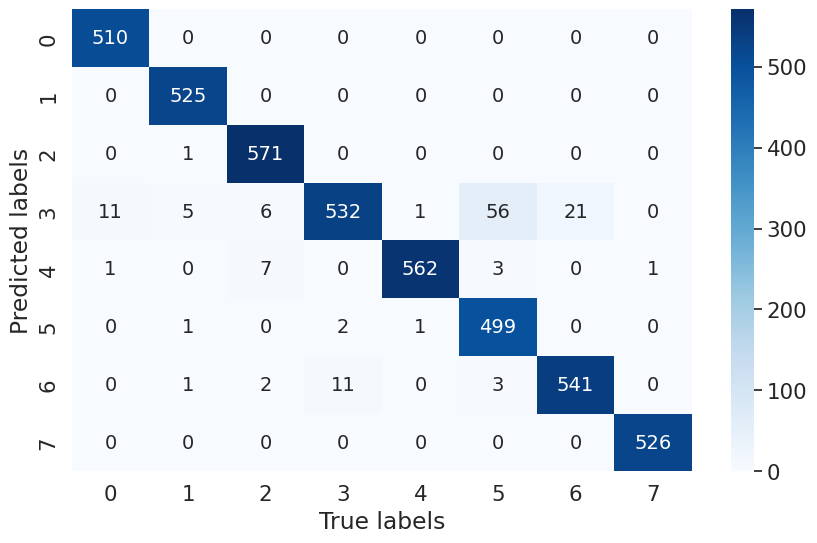

In [ ]:
# Predict class probabilities and get predicted classes
train_predictions = ft_model.predict(X_test*255.0, verbose=0)
train_predictions = np.argmax(train_predictions, axis=-1)

# Extract ground truth classes
train_gt = np.argmax(y_test, axis=-1)

# Calculate and display training set accuracy
train_accuracy = accuracy_score(train_gt, train_predictions)
print(f'Accuracy score over the train set: {round(train_accuracy, 4)}')

# Calculate and display training set precision
train_precision = precision_score(train_gt, train_predictions, average='weighted')
print(f'Precision score over the train set: {round(train_precision, 4)}')

# Calculate and display training set recall
train_recall = recall_score(train_gt, train_predictions, average='weighted')
print(f'Recall score over the train set: {round(train_recall, 4)}')

# Calculate and display training set F1 score
train_f1 = f1_score(train_gt, train_predictions, average='weighted')
print(f'F1 score over the train set: {round(train_f1, 4)}')

# Compute the confusion matrix
#cm = confusion_matrix(train_gt, train_predictions)
cm = confusion_matrix(train_predictions, train_gt)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)
# Plot the confusion matrix with class labels
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=['0', '1', '2', '3', '4', '5', '6', '7'], yticklabels=['0', '1', '2', '3', '4', '5', '6', '7'], cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()